In [136]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import sklearn### machine learning library
import cv2## image processing
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns### visualizations
import datetime
import pathlib
import io
import os
import re
import string
import time
from numpy import random
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (Dense,Flatten,SimpleRNN,InputLayer,Conv1D,Bidirectional,GRU,LSTM,BatchNormalization,Dropout,Input, Embedding,TextVectorization)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from google.colab import drive
from google.colab import files
from tensorboard.plugins import projector

In [138]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Preparation

## Data Download

In [88]:
!wget https://www.manythings.org/anki/fra-eng.zip

--2023-12-07 16:13:54--  https://www.manythings.org/anki/fra-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7833145 (7.5M) [application/zip]
Saving to: ‘fra-eng.zip.1’

fra-eng.zip.1       100%[===================>]   7.47M  14.9MB/s    in 0.5s    

2023-12-07 16:13:55 (14.9 MB/s) - ‘fra-eng.zip.1’ saved [7833145/7833145]



In [89]:
!unzip "/content/fra-eng.zip" -d "/content/dataset/"

Archive:  /content/fra-eng.zip
replace /content/dataset/_about.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/dataset/_about.txt  
replace /content/dataset/fra.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/dataset/fra.txt  


## Kaggle Dataset

In [90]:
# !pip install -q kaggle
# #!mkdir ~/.kaggle
# # !cp kaggle.json ~/.kaggle/
# # !chmod 600 /root/.kaggle/kaggle.json
# !kaggle datasets download -d dhruvildave/en-fr-translation-dataset

In [91]:
!unzip "/content/en-fr-translation-dataset.zip" -d "/content/dataset/"

unzip:  cannot find or open /content/en-fr-translation-dataset.zip, /content/en-fr-translation-dataset.zip.zip or /content/en-fr-translation-dataset.zip.ZIP.


In [92]:
dataset = tf.data.experimental.CsvDataset(
  "/content/dataset/en-fr.csv",
  [
    tf.string,
    tf.string
  ],
)

## Data Processing

In [139]:
text_dataset=tf.data.TextLineDataset("/content/dataset/fra.txt")

In [140]:
VOCAB_SIZE=20000
ENGLISH_SEQUENCE_LENGTH=64
FRENCH_SEQUENCE_LENGTH=64
EMBEDDING_DIM=300
BATCH_SIZE=64

In [141]:
english_vectorize_layer=TextVectorization(
    standardize='lower_and_strip_punctuation',
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=ENGLISH_SEQUENCE_LENGTH
)

In [142]:
french_vectorize_layer=TextVectorization(
    standardize='lower_and_strip_punctuation',
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=FRENCH_SEQUENCE_LENGTH
)

In [143]:
def selector(input_text):
  split_text=tf.strings.split(input_text,'\t')
  return {'input_1':split_text[0:1],'input_2':'starttoken '+split_text[1:2]},split_text[1:2]+' endtoken'

In [144]:
split_dataset=text_dataset.map(selector)

In [145]:
def separator(input_text):
  split_text=tf.strings.split(input_text,'\t')
  return split_text[0:1],'starttoken '+split_text[1:2]+' endtoken'

In [146]:
init_dataset=text_dataset.map(separator)

In [147]:
for i in split_dataset.take(3):
  print(i)

({'input_1': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, 'input_2': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'starttoken Va !'], dtype=object)>}, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Va ! endtoken'], dtype=object)>)
({'input_1': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, 'input_2': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'starttoken Marche.'], dtype=object)>}, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Marche. endtoken'], dtype=object)>)
({'input_1': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, 'input_2': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'starttoken En route !'], dtype=object)>}, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'En route ! endtoken'], dtype=object)>)


In [148]:
english_training_data=init_dataset.map(lambda x,y:x)### input x,y and output x
english_vectorize_layer.adapt(english_training_data)#### adapt the vectorize_layer to the training data

In [149]:
french_training_data=init_dataset.map(lambda x,y:y)### input x,y,z and output y
french_vectorize_layer.adapt(french_training_data)#### adapt the vectorize_layer to the training data

In [150]:
def vectorizer(inputs,output):
  return {'input_1':english_vectorize_layer(inputs['input_1']),
          'input_2':french_vectorize_layer(inputs['input_2'])},french_vectorize_layer(output)

In [151]:
split_dataset

<_MapDataset element_spec=({'input_1': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'input_2': TensorSpec(shape=(None,), dtype=tf.string, name=None)}, TensorSpec(shape=(None,), dtype=tf.string, name=None))>

In [152]:
dataset=split_dataset.map(vectorizer)

In [153]:
for i in split_dataset.take(3):
  print(i)

({'input_1': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, 'input_2': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'starttoken Va !'], dtype=object)>}, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Va ! endtoken'], dtype=object)>)
({'input_1': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, 'input_2': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'starttoken Marche.'], dtype=object)>}, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Marche. endtoken'], dtype=object)>)
({'input_1': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, 'input_2': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'starttoken En route !'], dtype=object)>}, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'En route ! endtoken'], dtype=object)>)


In [154]:
for i in dataset.take(1):
  print(i)

({'input_1': <tf.Tensor: shape=(1, 64), dtype=int64, numpy=
array([[45,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]])>, 'input_2': <tf.Tensor: shape=(1, 64), dtype=int64, numpy=
array([[  2, 104,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]])>}, <tf.Tensor: shape=(1, 64), dtype=int64, numpy=
array([[104,   3,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,

In [155]:
dataset

<_MapDataset element_spec=({'input_1': TensorSpec(shape=(None, 64), dtype=tf.int64, name=None), 'input_2': TensorSpec(shape=(None, 64), dtype=tf.int64, name=None)}, TensorSpec(shape=(None, 64), dtype=tf.int64, name=None))>

In [156]:
dataset=dataset.shuffle(2048).unbatch().batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

In [157]:
dataset

<_PrefetchDataset element_spec=({'input_1': TensorSpec(shape=(None, 64), dtype=tf.int64, name=None), 'input_2': TensorSpec(shape=(None, 64), dtype=tf.int64, name=None)}, TensorSpec(shape=(None, 64), dtype=tf.int64, name=None))>

In [158]:
NUM_BATCHES=int(200000/BATCH_SIZE)

In [159]:
train_dataset=dataset.take(int(0.9*NUM_BATCHES))
val_dataset=dataset.skip(int(0.9*NUM_BATCHES))

In [160]:
train_dataset

<_TakeDataset element_spec=({'input_1': TensorSpec(shape=(None, 64), dtype=tf.int64, name=None), 'input_2': TensorSpec(shape=(None, 64), dtype=tf.int64, name=None)}, TensorSpec(shape=(None, 64), dtype=tf.int64, name=None))>

# Modeling

In [161]:
NUM_UNITS=256

In [162]:
### ENCODER
input = Input(shape=(ENGLISH_SEQUENCE_LENGTH,), dtype="int64", name="input_1")
x=Embedding(VOCAB_SIZE, EMBEDDING_DIM, )(input)
encoded_input=Bidirectional(GRU(NUM_UNITS), )(x)

### DECODER
shifted_target=Input(shape=(FRENCH_SEQUENCE_LENGTH,), dtype="int64", name="input_2")
x=Embedding(VOCAB_SIZE,EMBEDDING_DIM,)(shifted_target)
x = GRU(NUM_UNITS*2, return_sequences=True)(x, initial_state=encoded_input)

### OUTPUT
x = Dropout(0.5)(x)
target=Dense(VOCAB_SIZE,activation="softmax")(x)
seq2seq_gru=Model([input,shifted_target],target)
seq2seq_gru.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64)]                 0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 64)]                 0         []                            
                                                                                                  
 embedding_6 (Embedding)     (None, 64, 300)              6000000   ['input_1[0][0]']             
                                                                                                  
 embedding_7 (Embedding)     (None, 64, 300)              6000000   ['input_2[0][0]']             
                                                                                            

In [163]:
class BLEU(tf.keras.metrics.Metric):
    def __init__(self,name='bleu_score'):
        super(BLEU,self).__init__()
        self.bleu_score=0

    def update_state(self,y_true,y_pred,sample_weight=None):
      y_pred=tf.argmax(y_pred,-1)
      self.bleu_score=0
      for i,j in zip(y_pred,y_true):
        tf.autograph.experimental.set_loop_options()

        total_words=tf.math.count_nonzero(i)
        total_matches=0
        for word in i:
          if word==0:
            break
          for q in range(len(j)):
            if j[q]==0:
              break
            if word==j[q]:
              total_matches+=1
              j=tf.boolean_mask(j,[False if y==q else True for y in range(len(j))])
              break

        self.bleu_score+=total_matches/total_words

    def result(self):
        return self.bleu_score/BATCH_SIZE

In [178]:
seq2seq_gru.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(5e-4),)
    #metrics=[BLEU()])
    #metrics = ["accuracy"])
    #run_eagerly=True))

In [165]:
checkpoint_filepath = '/content/drive/MyDrive/nlp/translation/lstm.h5'
# model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath=checkpoint_filepath,
#     monitor=['val_loss','val_accuracy'],
#     mode='min',
#     save_best_only=True,)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',  # Monitor both validation loss and validation accuracy
    mode='min',  # If monitoring loss, use 'min'. If monitoring accuracy, use 'max'.
    save_best_only=True,
)

In [166]:
history=seq2seq_gru.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=15,
    callbacks=[model_checkpoint_callback])

Epoch 1/15
   2812/Unknown - 337s 118ms/step - loss: 0.4678

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2812/2812 [==============================] - 401s 141ms/step - loss: 0.4678 - val_loss: 0.7149
Epoch 2/15
2812/2812 [==============================] - 387s 137ms/step - loss: 0.2733 - val_loss: 0.6295
Epoch 3/15
2812/2812 [==============================] - 388s 138ms/step - loss: 0.2124 - val_loss: 0.5816
Epoch 4/15
2812/2812 [==============================] - 386s 137ms/step - loss: 0.1767 - val_loss: 0.5511
Epoch 5/15
2812/2812 [==============================] - 387s 137ms/step - loss: 0.1532 - val_loss: 0.5506
Epoch 6/15
2812/2812 [==============================] - 386s 137ms/step - loss: 0.1362 - val_loss: 0.5494
Epoch 7/15
2812/2812 [==============================] - 383s 136ms/step - loss: 0.1235 - val_loss: 0.5431
Epoch 8/15
2812/2812 [==============================] - 387s 137ms/step - loss: 0.1136 - val_loss: 0.5396
Epoch 9/15
2812/2812 [==============================] - 386s 137ms/step - loss: 0.1057 - val_loss: 0.5362
Epoch 10/15
2812/2812 [==============================] - 

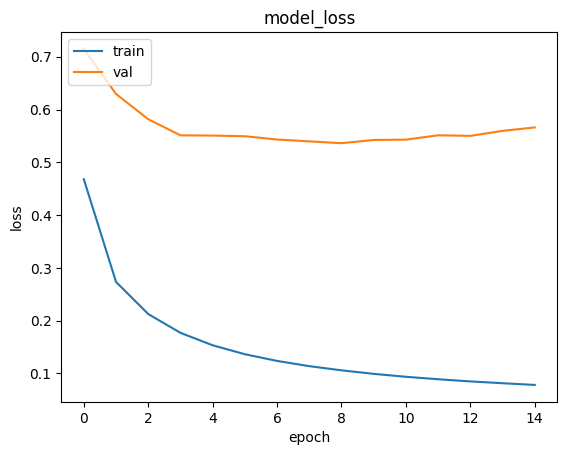

In [167]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [168]:
print(history.history.keys())

dict_keys(['loss', 'val_loss'])


In [179]:
seq2seq_gru.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(5e-4),
    #metrics=[BLEU()])
    metrics = ["accuracy"])
    #run_eagerly=True))

In [180]:
checkpoint_filepath = '/content/drive/MyDrive/nlp/translation/lstm.h5'
# model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath=checkpoint_filepath,
#     monitor=['val_loss','val_accuracy'],
#     mode='min',
#     save_best_only=True,)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',  # Monitor both validation loss and validation accuracy
    mode='max',  # If monitoring loss, use 'min'. If monitoring accuracy, use 'max'.
    save_best_only=True,
)

In [181]:
history=seq2seq_gru.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=15,
    callbacks=[model_checkpoint_callback])

Epoch 1/15
2812/2812 [==============================] - 490s 173ms/step - loss: 0.0581 - accuracy: 0.9830 - val_loss: 0.6293 - val_accuracy: 0.9108
Epoch 2/15
2812/2812 [==============================] - 473s 168ms/step - loss: 0.0548 - accuracy: 0.9837 - val_loss: 0.6242 - val_accuracy: 0.9113
Epoch 3/15
2812/2812 [==============================] - 468s 166ms/step - loss: 0.0536 - accuracy: 0.9840 - val_loss: 0.6253 - val_accuracy: 0.9112
Epoch 4/15
2812/2812 [==============================] - 471s 167ms/step - loss: 0.0527 - accuracy: 0.9842 - val_loss: 0.6322 - val_accuracy: 0.9112
Epoch 5/15
2812/2812 [==============================] - 470s 167ms/step - loss: 0.0519 - accuracy: 0.9843 - val_loss: 0.6359 - val_accuracy: 0.9112
Epoch 6/15
2812/2812 [==============================] - 469s 167ms/step - loss: 0.0513 - accuracy: 0.9845 - val_loss: 0.6377 - val_accuracy: 0.9109
Epoch 7/15
2812/2812 [==============================] - 470s 167ms/step - loss: 0.0506 - accuracy: 0.9846 - val_

In [182]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


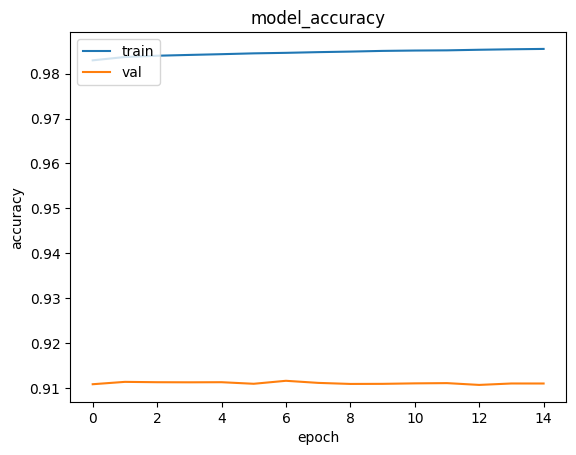

In [184]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Evaluation

In [185]:
seq2seq_gru.evaluate(val_dataset)

779/779 [==============================] - 84s 76ms/step - loss: 0.6692 - accuracy: 0.9110


[0.6692100167274475, 0.9109768271446228]

## Testing

In [186]:
index_to_word={x:y for x, y in zip(range(len(french_vectorize_layer.get_vocabulary())),
                                   french_vectorize_layer.get_vocabulary())}

In [187]:
def translator(english_sentence):
  tokenized_english_sentence=english_vectorize_layer([english_sentence])
  shifted_target='starttoken'

  for i in range(FRENCH_SEQUENCE_LENGTH):
    tokenized_shifted_target=french_vectorize_layer([shifted_target])
    output=seq2seq_gru.predict([tokenized_english_sentence,tokenized_shifted_target])
    french_word_index=tf.argmax(output,axis=-1)[0][i].numpy()
    current_word=index_to_word[french_word_index]
    if current_word=='endtoken':
      break
    shifted_target+=' '+current_word
  return shifted_target[11:]

In [188]:
translator('What makes you think that is not true?')

1/1 [==============================] - 0s 23ms/step


'questce qui vous fait penser que ce nest pas vrai'

In [189]:
word_to_index={y:x for x, y in zip(range(len(french_vectorize_layer.get_vocabulary())),
                                   french_vectorize_layer.get_vocabulary())}

In [190]:
word_to_index

{'': 0,
 '[UNK]': 1,
 'starttoken': 2,
 'endtoken': 3,
 'je': 4,
 'de': 5,
 'pas': 6,
 'que': 7,
 'ne': 8,
 'le': 9,
 'à': 10,
 'la': 11,
 'vous': 12,
 'tom': 13,
 'il': 14,
 'est': 15,
 'tu': 16,
 'un': 17,
 'ce': 18,
 'a': 19,
 'nous': 20,
 'les': 21,
 'une': 22,
 'en': 23,
 'jai': 24,
 'suis': 25,
 'pour': 26,
 'me': 27,
 'faire': 28,
 'cest': 29,
 'dans': 30,
 'plus': 31,
 'des': 32,
 'elle': 33,
 'ça': 34,
 'tout': 35,
 'qui': 36,
 'te': 37,
 'fait': 38,
 'du': 39,
 'ma': 40,
 'mon': 41,
 'veux': 42,
 'avec': 43,
 'se': 44,
 'au': 45,
 'si': 46,
 'et': 47,
 'cette': 48,
 'sont': 49,
 'y': 50,
 'quil': 51,
 'très': 52,
 'pense': 53,
 'cela': 54,
 'nest': 55,
 'son': 56,
 'sur': 57,
 'sais': 58,
 'votre': 59,
 'pourquoi': 60,
 'dit': 61,
 'temps': 62,
 'être': 63,
 'été': 64,
 'était': 65,
 'peux': 66,
 'moi': 67,
 'nai': 68,
 'chose': 69,
 'ici': 70,
 'jamais': 71,
 'ils': 72,
 'lui': 73,
 'comment': 74,
 'où': 75,
 'bien': 76,
 'estce': 77,
 'ton': 78,
 'quelque': 79,
 'vraiment':